# Analysis of tutoring center sign-in data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
plt.rcParams['figure.figsize'] = (10.0, 8.0)

Read in the data kept in the ..\Dropbox\sign_in_exports folder
Right now we're just manually grabbing one csv file.  But we could script this to grab the most recent file in the folder.

In [2]:
df = pd.read_csv(r'C:\Users\Ivan\Desktop\sign_in_export_2015-10-28.csv')
#df = pd.read_csv(r'\Users\Jonathan\Dropbox\sign_in_exports\sign_in_export_2015-11-05.csv')

Let's now create a datetime index to get days of the week and other datetime functions below.

In [3]:
df['timestamp'] = pd.to_datetime(df.Date + ' ' + df.Time)
df = df.set_index(pd.DatetimeIndex(df.timestamp))

In [4]:
weekmask =['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']

df['day'] = [weekmask[date.dayofweek] for date in df.index]
#makes weekdays into a category ordered by weekmask order
df['day']= df['day'].astype('category')
df['day']=  df['day'].cat.reorder_categories(weekmask[0:6], ordered=True)

df['hour']= [date.hour for date in df.index]


#### The most popular days of the week:

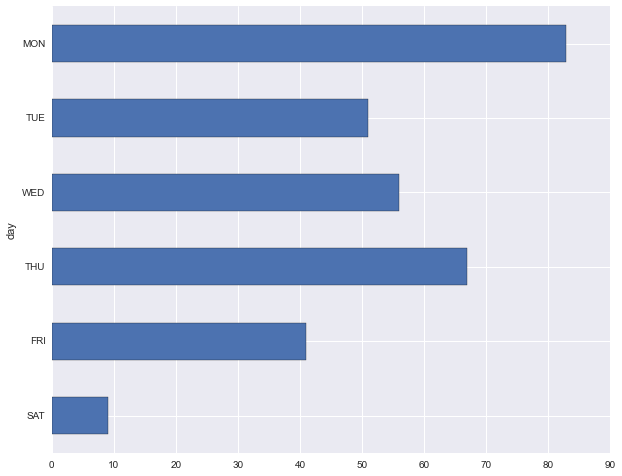

In [5]:
grouped = df.groupby('day').size().sort_index(ascending= False).plot(kind='barh')

Group by day and hour to count the number of visits in each day-hour cell.  Then reset_index to convert the (day,hour) multindex into a dataframe with columns for day, hour and visits.  After all that use a (groupby) pivot table to create the df_heatmap dataframe with hour rows and day columns. Exclude visits that might have been misclassified as having happened outside tutoring hours (8am-9pm).  Note: these get created when no hour was indicated on the sign-in.

In [6]:
dfu = pd.DataFrame(df.groupby([df.day,df.hour]).size())
dfu.reset_index(inplace=True) 
dfu.columns = ['hour','day', 'visits']

In [7]:
df_heatmap = dfu.pivot('day','hour','visits').fillna(0)
df_heatmap = df_heatmap.loc[8:21,]

A heatmap of the popular Weekdays/Hours to visit the tutoring center.

c:\users\ivan\anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


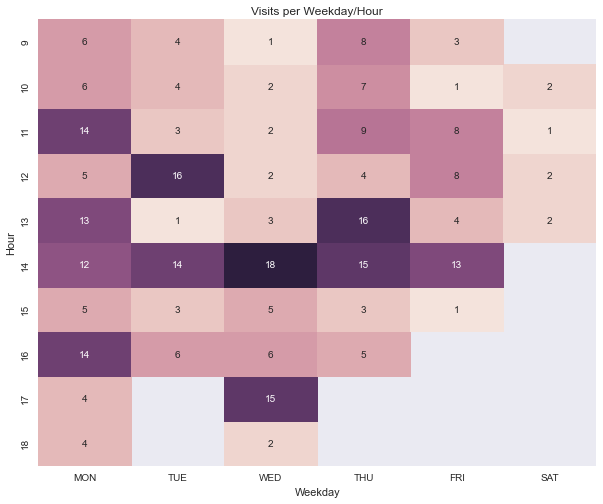

In [8]:
# Heatmap ignores values in mask. 
mask = ( df_heatmap ==0)
sns.heatmap(df_heatmap, annot=True, mask = mask,cbar=False)
plt.ylabel('Hour')
plt.xlabel('Weekday')
plt.title('Visits per Weekday/Hour')
plt.show()

# Summary statistics

Let's get a cumulative visits time-series

In [9]:
day_count = df.groupby('Date').size()
df_Day = pd.DataFrame({'Count': day_count})

Fill in the missing dates 

In [10]:
idx = pd.date_range(df_Day.index.min(), df_Day.index.max())
df_Day.index = pd.DatetimeIndex(df_Day.index)
df_day = df_Day.reindex(idx,fill_value=0)

## Visits by date

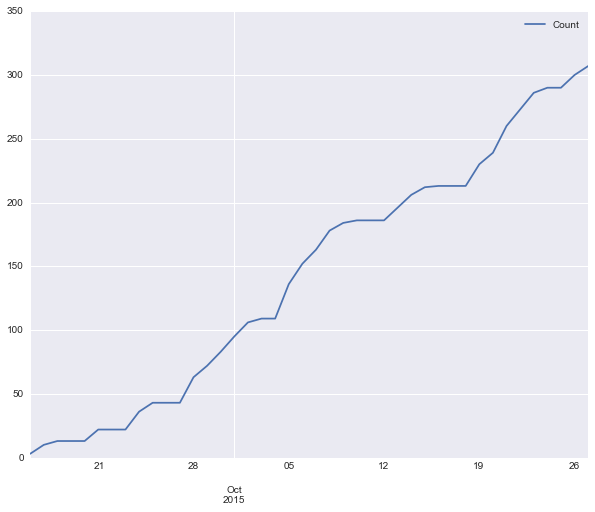

In [11]:
df_day.cumsum().plot()

## By course and instructor

In [12]:
byCourse = df.groupby(['Catalog Num'])
df_Course = byCourse.size().sort_values(ascending=False)
df_Course

Catalog Num
10000    103
30000     54
20000     34
34000     24
22100     22
35500     16
34500     14
36500     10
32100      9
30100      7
20100      5
33000      2
21000      1
73200      1
26000      1
39556      1
36600      1
30500      1
dtype: int64

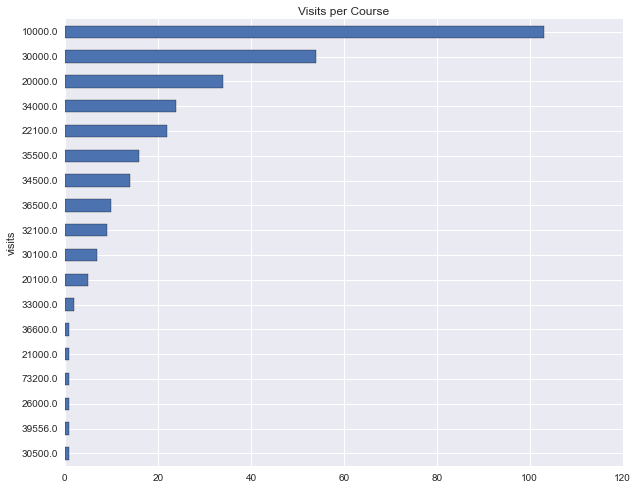

In [13]:
df_Course.sort_values().plot(kind='barh')
plt.ylabel("visits")
plt.title('Visits per Course')
plt.show()

In [14]:
byCourseProf = df.groupby(['Catalog Num','Instructor'])
df_CourseProf = byCourseProf.size().sort_values(ascending=False)
df_CourseProf

Catalog Num  Instructor  
10000        George          74
30000        Wright          52
34000        Conning         24
20000        Basu            21
35500        George          16
34500        Sevak           14
22100        Nugent          14
10000        Filer           13
             Goodspeed       11
36500        Ma               8
32100        Gharehogozli     8
20000        Deb              6
             Nugent           6
30100        Silverstein      5
22100        Demir            5
10000        Chernick         5
20100        Abreu            4
22100        Leboeuf          3
30000        Nyman            2
30100        Agbeyegbe        2
33000        Gurevich         2
36500        Lu               2
26000        Nyman            1
20100        Agbeyegbe        1
39556        Chaterjee        1
20000        Sevak            1
30500        Baker            1
32100        Leboeuf          1
36600        Carias           1
73200        Filer            1
dtype: int64

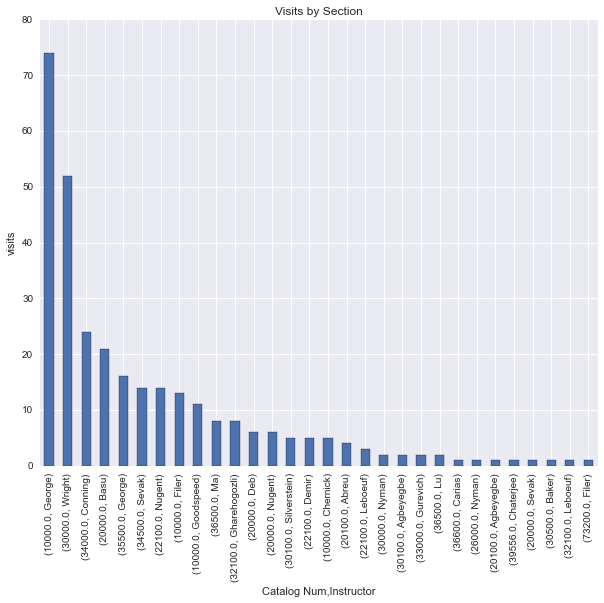

In [15]:
df_CourseProf.sort_values(ascending=False).plot(kind='bar')
plt.ylabel("visits")
plt.title('Visits by Section')
plt.ylabel("visits")
plt.show()

##  Some things we could do
   -  Number of unique visitors 
   -  Cumulative plot could disagregate by Purpose (drop-in, review)
   -  Agree on condensed summary report to send profs
       - 'this week'
       - 'semester to date'
   - more detailed report to profs
       - list of students
 